# **Final Test**

  * You can use Colab or your local installation
  * Rename the notebook with your Surname
  * SEND THE .ipynb file to `marco.milanesio@univ-cotedazur.fr` 
  * **DEADLINE** 12-01-2021 at 23h59.

## Usual preamble to a `Spark` notebook on google.colab...

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
update-alternatives: error: error creating symbolic link '/etc/alternatives/java.dpkg-tmp': Permission denied
java version "1.8.0_45"
Java(TM) SE Runtime Environment (build 1.8.0_45-b14)
Java HotSpot(TM) 64-Bit Server VM (build 25.45-b02, mixed mode)


Let's load the data.


In [2]:
!ls

boston.csv  exam.ipynb


You should have now `boston.csv` in your folder.

## ... or continue from here if you run locally on your machine

## Housing prices in Boston

The goal is to predict the housing prices in the Boston area.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

## 0 - Create a spark session named 'houses'

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .appName("houses") \
    .getOrCreate()

## 1 - Load the `boston.csv` file into the session
Use proper values for `inferSchema` and `header`, depending on the file itself...

**CALL IT `bostondf`** Otherwise some code may not work later

In [5]:
bostondf = (spark
            .read
            .format("csv")
            .options(header=True, inferSchema=True)
            .load("boston.csv"))

## 2 - Print the dataframe schema

In [6]:
bostondf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



## 3 - Show the first 3 rows of the dataframe

In [15]:
bostondf.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|_c0|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|  2|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|  3|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



## 4 - Output basic stats on the dataset.

*hint*: for readability purposes you can `transpose` a description dataframe.


In [13]:
# We drop the column _c0 as it is just an ID numbering of each entry

bostondf.drop("_c0").toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## 5 - Scatter Matrix (use pandas)

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


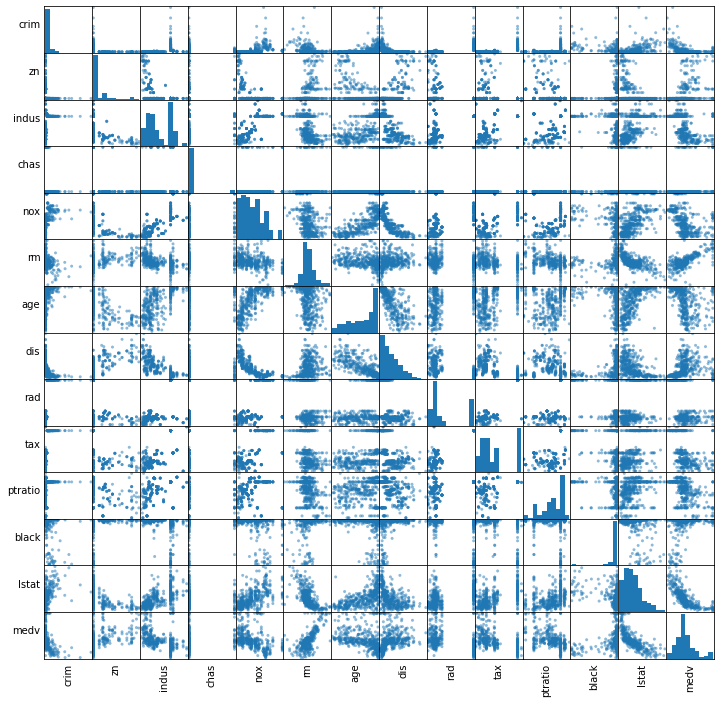

In [20]:
# DON"T CHANGE THIS. JUST RUN IT
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## 6 - Comment on the scatterplot

Scatterplot matrices are **good for determining rough linear correlations of data that contain continuous variables**. Scatterplot matrices are not so good for looking at discrete variables.

- The ``crim`` (per capita crime rate by town) variable seems to have a weak positive relationship with the variables: ``nox`` (nitrogen oxides concentration), ``age`` (proportion of owner-occupied units built prior to 1940), and ``lstat`` (lower status of the population). This may indicate that a higher crime incidence happens in neighboorhoods where buildings are older and where high concentration of nitrogen oxides are measure. The corrolary is that ``crim`` seems to have a negative relationship with the ``medv`` variable (median value of owner-occupied homes), incidentally our target variable.

- As a reminder, zoning laws regulate the use of land within a municipality. It controls the ways in which the land can be developed and what purposes the zoned land can serve. The ``zn`` (proportion of residential land zoned for lots over 25,000 sq.ft.) variable has a strong negative relationship with the ``indus`` (proportion of non-retail business acres per town) variable (logical as one excludes the other) and with the ``nox`` variable, indicating that residential zoning areas are selected away from places with a high concentration of nitrogen oxide. Similarly, the variable has a negative relationship with ``age`` and ``lsat``, indicating that the proportion of residential land zoned for lots over a certain size may target higher income earning areas and areas with a recent building history. The variable has a positive relationship with ``dis`` and ``medv`` (our target variable), indicating that zoning may happen in suburban areas rather than the city centers of Boston, which are historically poorer than the peripheries in the USA.


- ``indus`` has a strong positive relationship with ``nox``, expectedly as industries are more likely to reject that particle. It seems to have a negative relationship with ``medv``(our target variable), understandably as proximity to industries generally lowers house prices. 

- The variable ``chas`` (a dummy variable that is either 0 or 1) seems to be weakly correlated with the rest of the variables.

- ``nox`` seems to have a positive relationship with ``age``, indicating that areas where old buildings exist have a higher incidence of contamination. Meanwhile the variable has a negative relationship with ``dis`` and ``medv`` (our target variable).


- ``rm`` (average number of rooms per dwelling) does not seem to have a strong relationship with any feature except a weak positive relationship with ``zn`` and a negative relationship with ``lsat``, and incidentally a positive relationship with the ``medv`` target value. It indicates that house prices tend to rise with the room number while areas with a lower-income population have smaller houses.


- As mentioned prior, ``age`` has a negative relationship with ``zn``, ``dis``, and ``medv``, indicating that overall age of buildings in an area negatively impact the median value there. 


- ``dis`` seem to have a positive relationship with ``zn`` as mentioned prior, while showing a negative relationship with ``indus``, ``nox``, and ``age``. Meanwhile it has a weak positive relationship with our target variable ``medv``.


- Using the scatter matrix, it is hard to read ``rad`` (index of accessibility to radial highways) and ``ptratio`` (pupil-teacher ratio by town) as they are strongly clustered variable with regards to their impact on our target variable ``medv``. However they seem to have a negative impact trend.


- ``tax`` (full-value property-tax rate) does not seem to have strong relations with other features except maybe a negative relationship with ``medv`` (our target variable), indicating that the relative real estate tax rate on a house value decreases with it, penalizing smaller, cheaper houses.


- ``lsat`` has a positive relationship with ``crim``, ``indus``, ``nox``, and ``age`` while showing a negative relationship with ``rm``, ``dis``, and incidentally our target variable ``medv``. It indicates that lower-income neighboorhood are closer to old city centers, polluting industries, and areas of employment (highlitghing the US suburban city planning trend), which impacts the median value of houses.

To summarize, the target variable ``medv`` seems to show the following relationship with the available features:

| features | relationship with ``medv`` |
| ---      | ---          | 
| crim     | negative |
| zn       | positive |
| indus    | negative |
| chas     | *inconclusive* |
| nox      | negative |
| rm       | strong positive |
| age      | negative |
| dis      | weak positive |
| rad      | likely negative |
| tax      | likely negative |
| ptratio  | likely negative |
| black    | (see note) |
| lstat    | strong negative |

**Note:** The inclusion of race as part of a dataset raises concerns with regards to Ethics. As such we need to consider pruning that column from it (source: [AI has exacerbated racial bias in housing. Could it help eliminate it instead?](https://www.technologyreview.com/2020/10/20/1009452/ai-has-exacerbated-racial-bias-in-housing-could-it-help-eliminate-it-instead/) by the MIT Technology Review).  

## 7 - Compute all correlations with the target variable (`medv`)

*hint*: look at the `stat` attribute of the dataframe

In [68]:
# for column in bostondf.columns[1:-1]:
#     corr = round(bostondf.stat.corr("medv", column),4)
#     print(f"medv correlation with {column} is {corr}")
    
correlations = {column:round(bostondf.stat.corr("medv", column),4) 
                for column in bostondf.columns[1:-1]}

print("Feature's correlation metric with the target variable 'medv':")
correlations

Feature's correlation metric with the target variable 'medv':


{'crim': -0.3883,
 'zn': 0.3604,
 'indus': -0.4837,
 'chas': 0.1753,
 'nox': -0.4273,
 'rm': 0.6954,
 'age': -0.377,
 'dis': 0.2499,
 'rad': -0.3816,
 'tax': -0.4685,
 'ptratio': -0.5078,
 'black': 0.3335,
 'lstat': -0.7377}

## 8 - Data preparation

We keep all the variables, for now. **WHY?**

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [76]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

input_columns = bostondf.columns[1:-1] #Removes the _c0 and mdev columns

features = VectorAssembler(inputCols=input_columns, outputCol='features')
pipeline = Pipeline(stages=[features])

v_df = pipeline.fit(bostondf).transform(bostondf).select(["features", "medv"])
v_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Let's split the dataset into training and testing sets with a 70:30 ratio

In [77]:
# DONT CHANGE THIS, Just RUN IT.
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## 9 - Linear regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.regression).

Build a linear regression model to fit the data.
  * feature column: `features`
  * label column: `medv`
  * maxIter: 10
  * regParam: 0.3
  * elasticNetParam: 0.8  <- optional

Fit the model and print `coefficients` and `intercept`

In [93]:
from pyspark.ml.regression import LinearRegression

# Declares the model
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, 
                      featuresCol = 'features', labelCol = 'medv')

# Fits the model
lr_model = lr.fit(train_df)

# Prints the coefficients and intercept
print(f"Coefficients:\n {lr_model.coefficients}\n")
print(f"Intercept:\n {lr_model.intercept}")

Coefficients:
 [-0.04868013704913309,0.0007601436163417183,-0.013997776884000291,2.9294338712104193,-6.11970730793977,4.066407485517022,0.0,-0.7118970373758197,0.011352218578847597,0.0,-0.7081739117338332,0.008985542695662709,-0.5464245489911497]

Intercept:
 19.872022862787787


## 10 - Summary and RMSE

Print the summary of the model, the `RMSE` and the `r2` errors

In [94]:
# Summarizes the model over the training set
training_summary = lr_model.summary

In [96]:
# Prints some elements of the summary among available methods:
# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=summary#pyspark.ml.regression.LinearRegressionModel.summary
print(f"Number of iterations: {training_summary.totalIterations} " + 
      "(Recall the model starts with iteration 0, 'maxIter=10' implies " +
      "that there can be 11 iterations maximum).\n") 
print("Objective history of model (Objective function (scaled loss + regularization) at each iteration): " +
      f"{training_summary.objectiveHistory}.")

Number of iterations: 11 (Recall the model starts with iteration 0, 'maxIter=10' implies that there can be 11 iterations maximum).

Objective history of model (Objective function (scaled loss + regularization) at each iteration): [0.5000000000000004, 0.43333623200221005, 0.2499516162001023, 0.22822917538766893, 0.1970492668486725, 0.19245197741209102, 0.19166171405667184, 0.19074223787323946, 0.1890998604229851, 0.18882504146746876, 0.18854498077977827].


In [139]:
# Prints  the residuals summary, and the RMSE and r2 errors

# training_summary.residuals.show(10)
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"r2: {training_summary.r2}")

RMSE: 4.926642010194208
r2: 0.6997475954216142


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max.

What can you infer from this results? Is it good or is it bad?


## 11 - Predictions

Make preditions and evaluate the model (e.g., with `RMSE`). We will use a `RegressionEvaluator` for this.

In [135]:
lr_predictions = lr_model.transform(train_df)
lr_predictions.select("prediction","medv","features").show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.40708973853327|24.0|[0.00632,18.0,2.3...|
| 26.76570911311799|22.0|[0.01096,55.0,2.2...|
|31.188142689514073|32.7|[0.01301,35.0,1.5...|
| 37.11228047237381|50.0|[0.01381,80.0,0.4...|
| 29.80410868093991|29.1|[0.01439,60.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows



In [136]:
# DON'T TOUCH THIS. JUST RUN
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.699748


In [137]:
test_result = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.evaluate(lr_predictions))

Root Mean Squared Error (RMSE) on test data = 4.92664


In [141]:
print("numIterations: %d" % training_summary.totalIterations)
print("objectiveHistory: %s" % str(training_summary.objectiveHistory))

training_summary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.43333623200221005, 0.2499516162001023, 0.22822917538766893, 0.1970492668486725, 0.19245197741209102, 0.19166171405667184, 0.19074223787323946, 0.1890998604229851, 0.18882504146746876, 0.18854498077977827]
+-------------------+
|          residuals|
+-------------------+
| -6.407089738533269|
| -4.765709113117989|
| 1.5118573104859294|
| 12.887719527626189|
|-0.7041086809399069|
|-2.0286176271146026|
|  9.365721235931773|
| 10.177432999517144|
|  4.958305654290584|
| 2.8614082091098965|
|-1.9927681777093227|
|-0.3162381140640562|
| 0.7046265394314339|
|  -9.83607696372962|
| -3.381676287747947|
|  -3.86517541483159|
| 2.2910390133143856|
| 1.0392033024835179|
| -2.786384398094853|
| 3.4911556039543434|
+-------------------+
only showing top 20 rows



We can use the model to make some predictions on the testing set.

In [133]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 29.50482153412647|32.2|[0.00906,90.0,2.9...|
| 29.05257425773889|35.4|[0.01311,90.0,1.2...|
|16.666300699594853|18.9|[0.0136,75.0,4.0,...|
|29.939274102671284|31.6|[0.01432,100.0,1....|
|25.637431162516652|33.0|[0.01951,17.5,1.3...|
|19.541077460590106|20.1|[0.01965,80.0,1.7...|
| 37.95621634138299|50.0|[0.02009,95.0,2.6...|
| 35.31321892344004|42.3|[0.02177,82.5,2.0...|
|31.327569993942763|34.7|[0.02729,0.0,7.07...|
|26.813137486212575|25.0|[0.02875,28.0,15....|
| 26.35428126523265|28.7|[0.02985,0.0,2.18...|
|20.149401986659658|18.5|[0.03041,0.0,5.19...|
|28.807286595803802|31.2|[0.03049,55.0,3.7...|
| 29.44040983930339|34.9|[0.0315,95.0,1.47...|
|31.531703253567933|34.9|[0.03359,75.0,2.9...|
|20.750847200822992|19.5|[0.03427,0.0,5.19...|
|36.731328827296856|48.5|[0.0351,95.0,2.68...|
|21.705315889892066|20.9|[0.03548,80.0,3.6...|
|25.480471860

## 12 - Decision tree regression and Gradient-boosted tree regression

Try to do the same thing with these 2 regressors.
Which will result better? 

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

In [164]:
from pyspark.ml.regression import DecisionTreeRegressor

rmses = []
depths = []

for depth in list(range(1, 20)): #could use getGridParams
    
    dt = DecisionTreeRegressor(maxDepth=depth, 
                               featuresCol="features", 
                               labelCol="medv")
    dt_model = dt.fit(train_df)
    dt_predictions = dt_model.transform(test_df)
    dt_evaluator = RegressionEvaluator(labelCol="medv", 
                                       predictionCol="prediction", 
                                       metricName="rmse")
    
    rmses.append(dt_evaluator.evaluate(dt_predictions))
    depths.append(dt_model.getMaxDepth())

rmse = min(rmses)
depth = depths[rmses.index(rmse)]
print(f"minimum Root Mean Squared Error (RMSE) on test data, {round(rmse,4)}, " +
      f"was achieved at max_depth {depth}.")

minimum Root Mean Squared Error (RMSE) on test data, 4.091, was achieved at max_depth 4.


### Gradient-boosted tree regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor).

In [170]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxDepth=4, maxIter = 10,
                   labelCol="medv")
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 31.86805824633361|32.2|[0.00906,90.0,2.9...|
|  33.6860432926343|35.4|[0.01311,90.0,1.2...|
|17.766603159255567|18.9|[0.0136,75.0,4.0,...|
|28.322528070238352|31.6|[0.01432,100.0,1....|
|31.541813425172847|33.0|[0.01951,17.5,1.3...|
+------------------+----+--------------------+
only showing top 5 rows



In [171]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.88518
